# Import dataset
---

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils.layer_utils import count_params
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
import math
import pickle 
import seaborn as sns
import re
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import matplotlib.cm as cm

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/MyDrive"

Mounted at /content/gdrive


In [ ]:
dataset = os.path.join(root_dir, "SigNature/Datasets/SigNature_integration_HQ_augmented")
pickle_path = dataset + "/SigNature_integr_HQ_augmented.pickle"

Il dataset è importato nel seguente modo, x_train, x_val, x_test contengono le immagini, y_01 contengono le label Forged/Genuine, mentre y_id contengono gli id degli utenti a cui è riferita la firma.



In [ ]:
x_train, y_01_train, y_id_train = [], [], []
x_test, y_01_test, y_id_test = [], [], []
x_val, y_01_val, y_id_val = [], [], []

In [ ]:
def load_fast():
  f = open(pickle_path, "rb") 
  train_set, test_set, val_set = pickle.load(f)
  f.close()
  return train_set, test_set, val_set

In [ ]:
def load_slow():
  data_dir = os.path.join(dataset, "Train")
  for folder in tqdm(os.listdir(data_dir)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir, folder)
    n_imgs = len(os.listdir(path))
    n_val = math.ceil(0.1 * n_imgs)
    for i in range(n_val):
      img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
      img_obj = cv2.imread(img_path, 0)
      img_obj = np.array(img_obj).astype("float32") / 255
      x_val.append(img_obj)
      y_01_val.append(is_genuine)
      y_id_val.append(user_id)
    for i in range(n_val, n_imgs):
      img_path = os.path.join(data_dir, folder, os.listdir(path)[i])
      img_obj = cv2.imread(img_path, 0)
      img_obj = np.array(img_obj).astype("float32") / 255
      x_train.append(img_obj)
      y_01_train.append(is_genuine)
      y_id_train.append(user_id)

  data_dir = os.path.join(dataset, "Test")
  for folder in tqdm(os.listdir(data_dir)):
    is_genuine = 0 if "forged" in folder else 1
    user_id = int(re.findall('\d+', folder)[0])
    path = os.path.join(data_dir, folder)
    for img in os.listdir(path):
      img_path = os.path.join(data_dir, folder, img)
      img_obj = cv2.imread(img_path, 0)
      img_obj = np.array(img_obj).astype("float32") / 255
      x_test.append(img_obj)
      y_01_test.append(is_genuine)
      y_id_test.append(user_id)

  f = open(pickle_path, "wb") 
  pickle.dump([(x_train, y_01_train, y_id_train),
               (x_test, y_01_test, y_id_test),
               (x_val, y_01_val, y_id_val)], f)
  f.close()

In [ ]:
if os.path.isfile(pickle_path): 
  train_set, test_set, val_set = load_fast()
  x_train, y_01_train, y_id_train = train_set
  x_test, y_01_test, y_id_test = test_set
  x_val, y_01_val, y_id_val = val_set
else: 
  load_slow()

100%|██████████| 218/218 [00:05<00:00, 41.78it/s]


In [ ]:
print("Train", len(x_train), len(y_01_train), len(y_id_train))
print("Validation", len(x_val), len(y_01_val), len(y_id_val))
print("Test", len(x_test), len(y_01_test), len(y_id_test))

Train 5947 5947 5947
Validation 677 677 677
Test 757 757 757


# CNN forgery detection


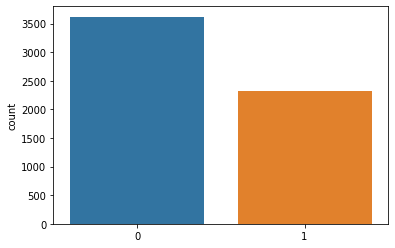

In [ ]:
sns.countplot(y_01_train)

## Preparing the data
---



Only 2 classes are needed: forged and genuine

In [ ]:
num_classes = 2

One hot encoding of the classes

In [ ]:
y_01_test = keras.utils.to_categorical(y_01_test, num_classes)
y_01_train = keras.utils.to_categorical(y_01_train, num_classes)
y_01_val = keras.utils.to_categorical(y_01_val, num_classes)

Espand dimensions for the CNN model input, the new correct shape is:
 128 x 256 x 1



In [ ]:
x_test = np.expand_dims(x_test, -1)
x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)

input_shape = (128, 256, 1)

Shuffle randomly the dataset to not bias the model in training phase

In [ ]:
x_train, y_01_train, y_id_train = shuffle(x_train, y_01_train, y_id_train)
x_test, y_01_test, y_id_test = shuffle(x_test, y_01_test, y_id_test)
x_val, y_01_val, y_id_val = shuffle(x_val, y_01_val, y_id_val)

## Building the network
---
number and dimension of the layers, optimization algorithms and regularization (this time mandatory), and some comments about the results (as seen in class).
any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

The neural network is described using Sequential api, in fact the simplicity of the network did not require the use of functional api.

The final network has 3 convolutional layers, 1 flatten layer, and 2 dense layers. Various number of convolutions and filters are tested


The activation function used for the hidden layers is the relu, this activation function allows you to quickly tow the network and solves the problem of gradient vanishing.

The sigmoid function was chosen as the output function, which is an appropriate output unit for the binary classification problem. In the problem under consideration, this returns a number between in the [0,1] interval.

The regularization technique used was the dropout. Various regularization techniques have been tested, but this is the one that has proved to be the most effective and efficient. In fact, in computational terms, training is faster, as a subset of the network is trained for each epoch. 

In [ ]:
keras.backend.clear_session()
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(num_classes, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 30, 128)      0

Various optimizers have been tested, in particular, good results have not been obtained for adadelta and adagrad, while other optimizers such as rmsprop and adam have been found to be more effective in minimizing the loss function. However, the choice fell on adam.

The binary_crossentropy has been chosen as the loss function, which refers to the cross-entropy function. Furthermore, this is closely related to the activation function of the output layer, and it's a proper loss for the classification problem.

The optimizer chosen for the problem is adam, this optimizer is adequate in most cases, it is an adaptive optimizer. https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

The initializer of the network weights is he_normal, this allows to initialize the network with small but different weights in the layer, in order to create an initial asymmetry state that favors the learning of the network. This empirically works well with the relu activations. 

## Analyze and comment the training results
here goes any comment/visualization of the training history and any initial consideration on the training results.


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor='val_f1_m', mode='max', verbose=1,
                   patience=10, restore_best_weights=True)

In [ ]:
from keras.callbacks import ModelCheckpoint
fBestModel = dataset + '/bestModel.h5'
bm_callback = ModelCheckpoint(fBestModel, monitor='val_f1_m', verbose=0, saveBestOnly=True)

Why use the f1 score

https://towardsdatascience.com/the-f1-score-bec2bbc38aa6#:~:text=The%20F1%20score%20is%20defined,when%20computing%20an%20average%20rate.&text=F1%20Score%20formula.

In [ ]:
epochs = 20
model.compile(loss = "binary_crossentropy", optimizer=Adam(), metrics=['accuracy', f1_m])
history = model.fit(x_train, y_01_train, validation_data=(x_val, y_01_val), batch_size = 128, epochs = epochs, callbacks=[bm_callback])

Epoch 1/20
47/47 [==============================] - 17s 329ms/step - loss: 0.8568 - accuracy: 0.6166 - f1_m: 0.5006 - val_loss: 0.5067 - val_accuracy: 0.7238 - val_f1_m: 0.7367
Epoch 2/20
47/47 [==============================] - 15s 312ms/step - loss: 0.4332 - accuracy: 0.8048 - f1_m: 0.8062 - val_loss: 0.2211 - val_accuracy: 0.9069 - val_f1_m: 0.9045
Epoch 3/20
47/47 [==============================] - 13s 285ms/step - loss: 0.2261 - accuracy: 0.9119 - f1_m: 0.9112 - val_loss: 0.1363 - val_accuracy: 0.9468 - val_f1_m: 0.9461
Epoch 4/20
47/47 [==============================] - 13s 285ms/step - loss: 0.1342 - accuracy: 0.9517 - f1_m: 0.9505 - val_loss: 0.1241 - val_accuracy: 0.9439 - val_f1_m: 0.9473
Epoch 5/20
47/47 [==============================] - 13s 285ms/step - loss: 0.0886 - accuracy: 0.9655 - f1_m: 0.9648 - val_loss: 0.0967 - val_accuracy: 0.9572 - val_f1_m: 0.9552
Epoch 6/20
47/47 [==============================] - 14s 310ms/step - loss: 0.0649 - accuracy: 0.9754 - f1_m: 0.9766

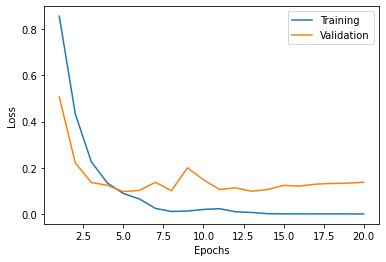

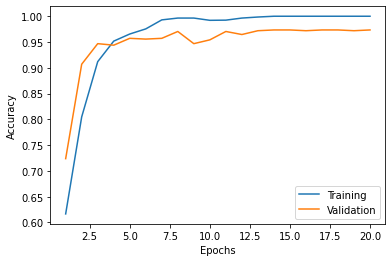

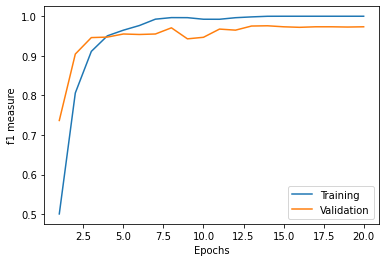

In [ ]:
x_plot = list(range(1,epochs +1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('f1 measure')
    plt.plot(x_plot, network_history.history['f1_m'])
    plt.plot(x_plot, network_history.history['val_f1_m'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

## Predictions on test set
Please describe the evaluation procedure, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather personal) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [ ]:
model.load_weights(dataset + "/bestModel.h5")
model.compile(loss = "binary_crossentropy", optimizer=Adam(), metrics=['accuracy', f1_m])

In [ ]:
score = model.evaluate(x_test, y_01_test, verbose=0)
print("Test loss", score[0])
print("Test accuracy", score[1])

Test loss 0.24756601452827454
Test accuracy 0.9537648558616638


In [ ]:
predictions = np.argmax(model.predict(x_test), axis=1)
predictions = keras.utils.to_categorical(predictions, num_classes)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_01_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       375
           1       0.95      0.96      0.95       382

   micro avg       0.95      0.95      0.95       757
   macro avg       0.95      0.95      0.95       757
weighted avg       0.95      0.95      0.95       757
 samples avg       0.95      0.95      0.95       757



## Predictions by user id


In this section is described , for each user, the performance evaluation.
 This is done mainly to undersand who are the users that performs better and worst, and to undestand why this happens.

In [ ]:
users_score = []

n = len(os.listdir(dataset + "/Test")) // 2
for i in tqdm(range(1, n + 1)):
  x_user = []
  y_user = []

  folder_g = str(i) + "_genuine"
  folder_f = str(i) + "_forged"
  
  for img in os.listdir(dataset + "/Test" + "/" + folder_g):
    path = os.path.join(dataset, "Test", folder_g, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user.append(img_obj)
    y_user.append(1)

  for img in os.listdir(dataset + "/Test" + "/" + folder_f):
    path = os.path.join(dataset, "Test", folder_f, img)
    img_obj = cv2.imread(path, 0)
    img_obj = np.array(img_obj).astype("float32") / 255
    x_user.append(img_obj)
    y_user.append(0)

  y_user = keras.utils.to_categorical(y_user, num_classes)
  x_user = np.expand_dims(x_user, -1)
  score = model.evaluate(x_user, y_user, verbose=0)

  predictions = np.argmax(model.predict(x_user), axis=1)
  predictions = keras.utils.to_categorical(predictions, num_classes)
  users_score.append((score, classification_report(predictions, y_user, zero_division=0)))

100%|██████████| 109/109 [00:23<00:00,  4.72it/s]


In [ ]:
labels = [ str(i) for i in range(1, n + 1)]

users_acc = [users_score[i][0][1] for i in range(n)]
users_f1 = [users_score[i][0][2] for i in range(n)]

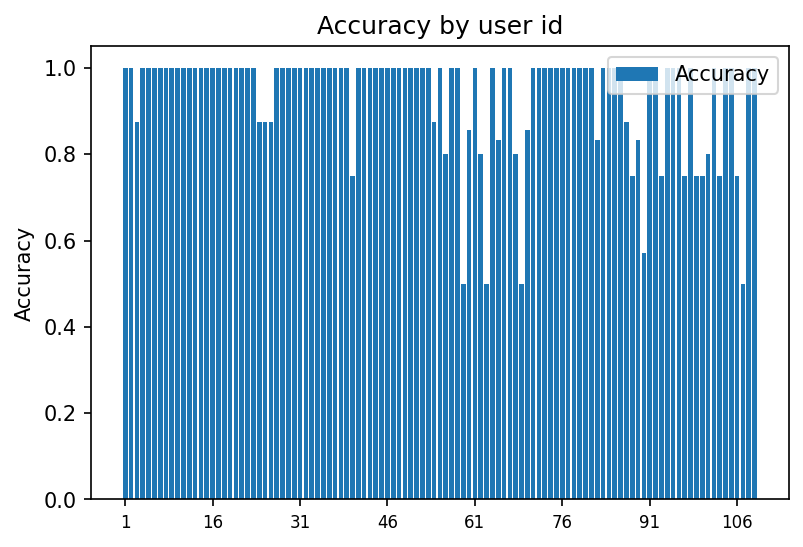

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
ax.bar(labels, users_acc, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by user id')
ax.legend()
fig.set_dpi(150)
plt.xticks(fontsize=8)
ax.set_xticks(np.arange(0, n, 15))
plt.figure()
plt.show()

In [ ]:
print("Max accuracy:", max(users_acc), "by the user", users_acc.index(max(users_acc))+1)
print("Min accuracy:", min(users_acc), "by the user", users_acc.index(min(users_acc))+1)

Max accuracy: 1.0 by the user 1
Min accuracy: 0.5 by the user 59


The behaviour behind the low accuracy for the user 107, and some other users, can
be due to the fact that the genuine and the forgery are very similar.
The behaviour behind the high accuracy for users, can be that the forgeries and the genuine are more different.


GradCAM can help up to understand better what the CNN does.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def heatmap(img, last_layer_name = "conv2d"):
  model.layers[-1].activation = None
  img = cv2.imread(img, 0)
  img = np.array(img).astype("float32") / 255
  img = np.expand_dims([img], -1)
  preds = np.argmax(model.predict(img), axis=1)
  print(preds)
  heatmap = make_gradcam_heatmap(img, model, last_layer_name)
  return heatmap

This is an example of what the CNN does for a user with high accuracy.
On the left there are the genuine images passed through the layers of the CNN.
On the right there are the forged images passed through the layers of the CNN.

In questo caso la rete riesce correttamente a classificare le due immagini, 
si nota come le feature maps delle genuine hanno particolare focus sulla linea della firma, mentre quelle della forged hanno focus sui contorni.

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


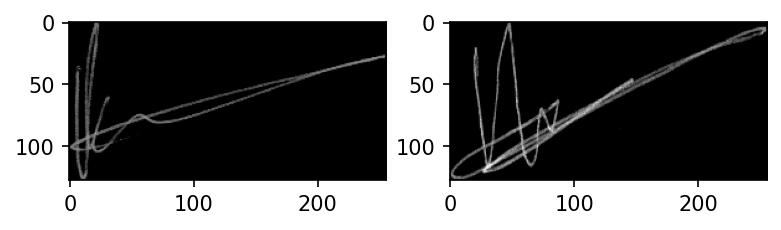

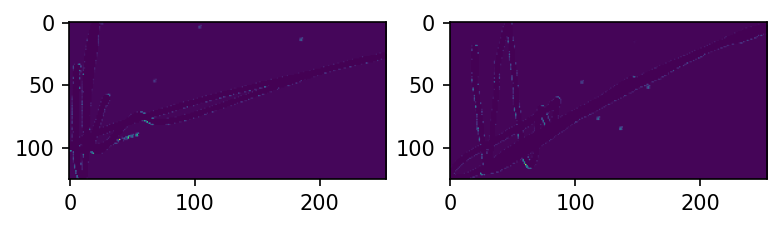

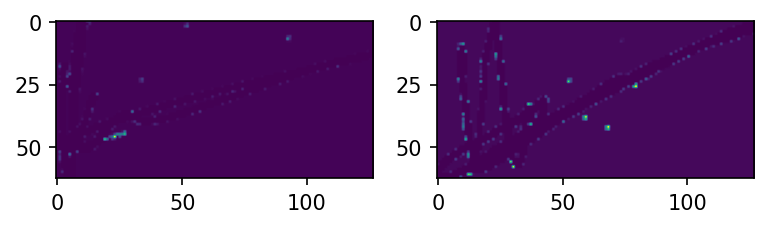

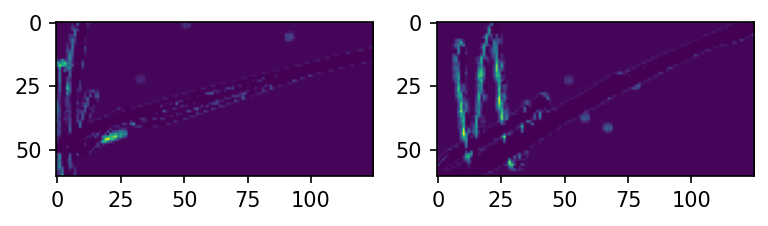

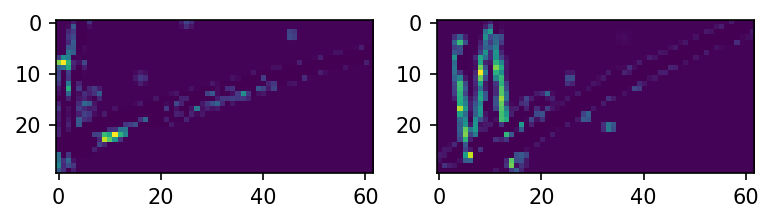

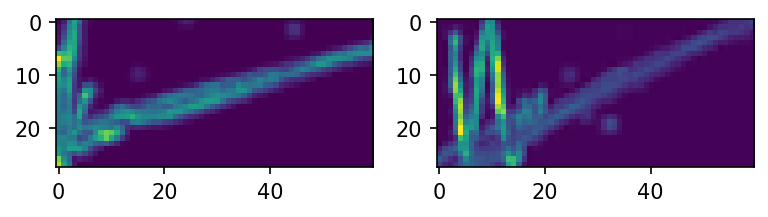

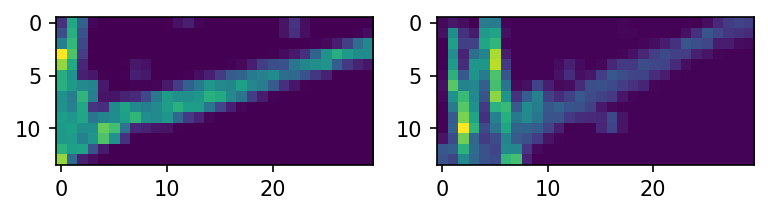

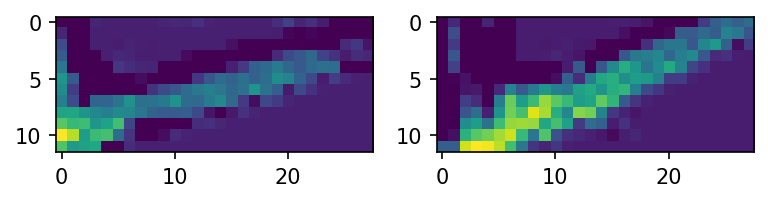

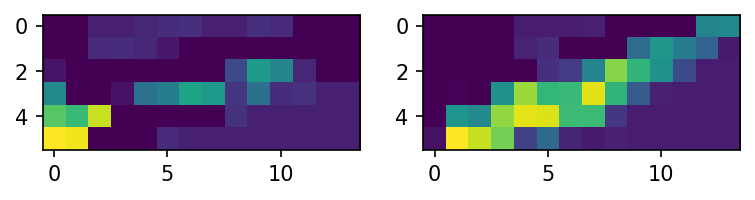

In [ ]:
fig , axarr = plt.subplots(1,2)
fig.set_dpi(150)
_ = axarr[0].imshow(cv2.cvtColor(cv2.imread(os.path.join(dataset,"Train", "59_genuine", "1.png")),
                                 cv2.COLOR_BGR2RGB))
_ = axarr[1].imshow(cv2.cvtColor(cv2.imread(os.path.join(dataset,"Train", "59_forged", "1.png")),
                                 cv2.COLOR_BGR2RGB))

for idx in range(len(model.layers)-5):
  layer = model.get_layer(index = idx).name
  fig , axarr = plt.subplots(1,2)
  fig.set_dpi(150)
  _ = axarr[0].imshow(heatmap(os.path.join(dataset,"Train", "59_genuine", "1.png"),
                            last_layer_name = layer))
  _ = axarr[1].imshow(heatmap(os.path.join(dataset,"Train", "59_forged", "1.png"),
                            last_layer_name = layer))

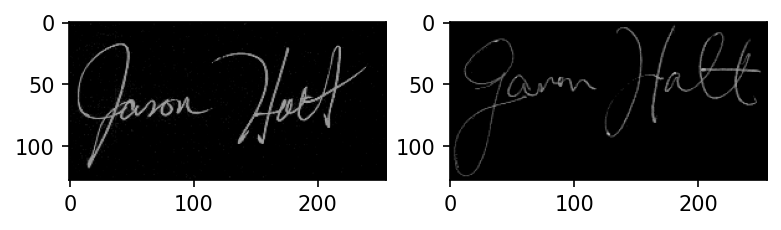

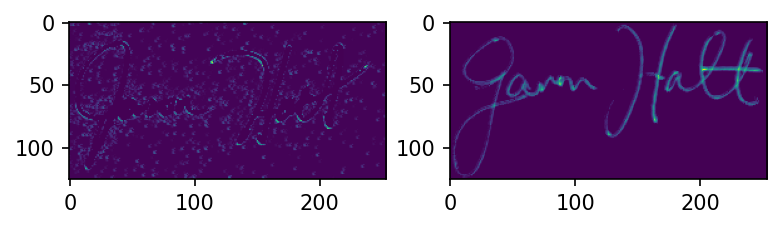

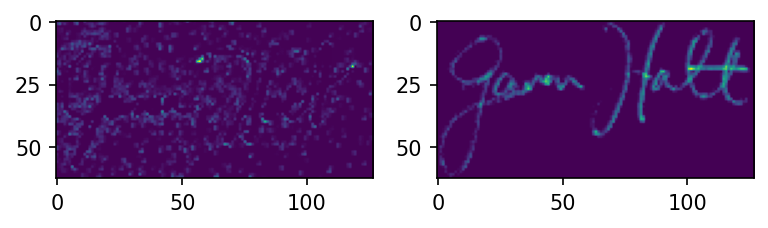

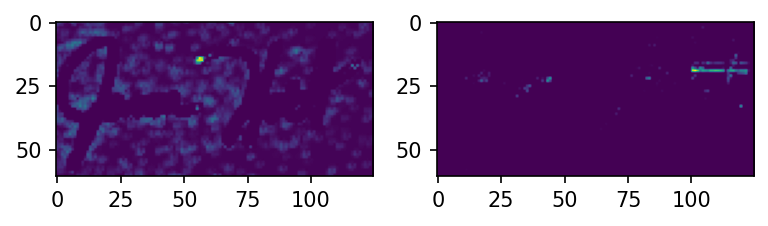

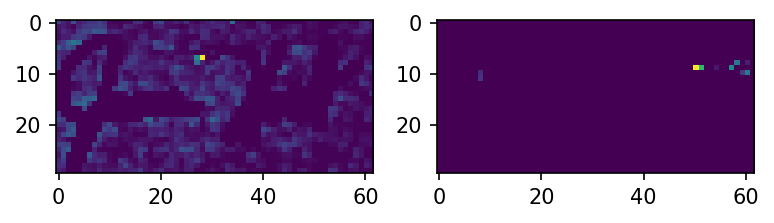

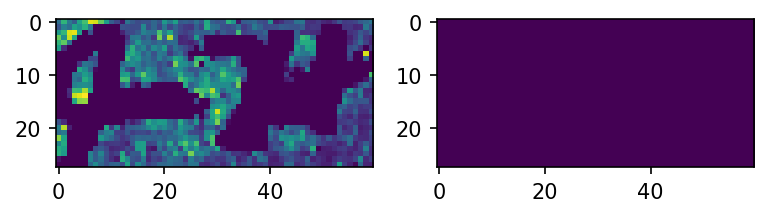

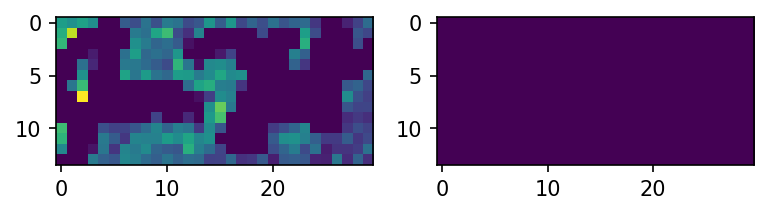

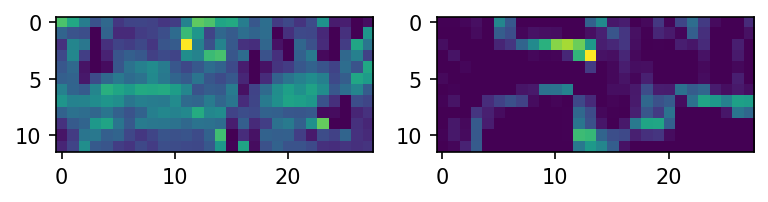

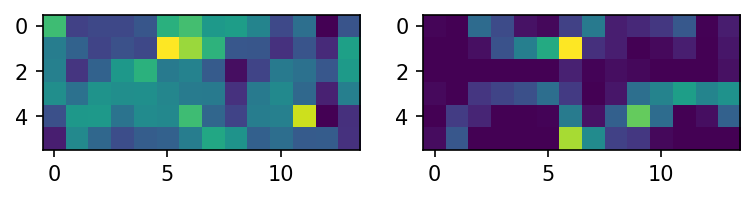

In [ ]:
genuine = os.path.join(dataset,"Train", "47_genuine", "1.png")
forged = os.path.join(dataset,"Train", "47_forged", "1.png")

fig , axarr = plt.subplots(1,2)
fig.set_dpi(150)
_ = axarr[0].imshow(cv2.cvtColor(cv2.imread(genuine), cv2.COLOR_BGR2RGB))
_ = axarr[1].imshow(cv2.cvtColor(cv2.imread(forged),cv2.COLOR_BGR2RGB))
for idx in range(len(model.layers)-5):
  layer = model.get_layer(index = idx).name
  fig , axarr = plt.subplots(1,2)
  fig.set_dpi(150)
  _ = axarr[0].imshow(heatmap(genuine, last_layer_name = layer))
  _ = axarr[1].imshow(heatmap(forged, last_layer_name = layer))

Per questo particolare utente, invece, la CNN si focalizza sulla firma sia per le forged e sia per le genuine. Non riesce quindi a distinguere le due classi, che si assomigliano molto.

# CNN user identification

In [ ]:
num_classes = len(set(y_id_train))

In [ ]:
y_id_train = list(map(lambda i: i - 1, y_id_train))
y_id_test = list(map(lambda i: i - 1, y_id_test))
y_id_val =  list(map(lambda i: i - 1, y_id_val))

In [ ]:
y_id_test = keras.utils.to_categorical(y_id_test, num_classes)
y_id_train = keras.utils.to_categorical(y_id_train, num_classes)
y_id_val = keras.utils.to_categorical(y_id_val, num_classes)

In [ ]:
input_shape = (128, 256, 1)

In [ ]:
keras.backend.clear_session()
model_id = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(256, kernel_size=(3, 3), kernel_initializer='he_normal', activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(num_classes, activation="softmax")
])

model_id.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 30, 128)      0

it is often advised that one starts at a small batch size, reaping the benefits of faster training dynamics, and steadily grows the batch size through training, also reaping the benefits of guaranteed convergence.

However, it is well known that too large of a batch size will lead to poor generalization (although currently it’s not known why this is so)

In [ ]:
epochs = 20
model_id.compile(loss = "categorical_crossentropy", optimizer=Adam(), metrics=['accuracy'])
history = model_id.fit(x_train, y_id_train, validation_data=(x_val, y_id_val), batch_size = 128, epochs = epochs, callbacks=[])

Epoch 1/20
93/93 [==============================] - 14s 144ms/step - loss: 2.7625 - accuracy: 0.4162 - val_loss: 0.9948 - val_accuracy: 0.7533
Epoch 2/20
93/93 [==============================] - 13s 140ms/step - loss: 0.3826 - accuracy: 0.8986 - val_loss: 0.5014 - val_accuracy: 0.8818
Epoch 3/20
93/93 [==============================] - 13s 140ms/step - loss: 0.0951 - accuracy: 0.9736 - val_loss: 0.3422 - val_accuracy: 0.9099
Epoch 4/20
93/93 [==============================] - 13s 140ms/step - loss: 0.0498 - accuracy: 0.9854 - val_loss: 0.3846 - val_accuracy: 0.9129
Epoch 5/20
93/93 [==============================] - 13s 140ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.4835 - val_accuracy: 0.9114
Epoch 6/20
93/93 [==============================] - 13s 141ms/step - loss: 0.0404 - accuracy: 0.9896 - val_loss: 0.4979 - val_accuracy: 0.9129
Epoch 7/20
93/93 [==============================] - 13s 141ms/step - loss: 0.0279 - accuracy: 0.9909 - val_loss: 0.5078 - val_accuracy: 0.8936

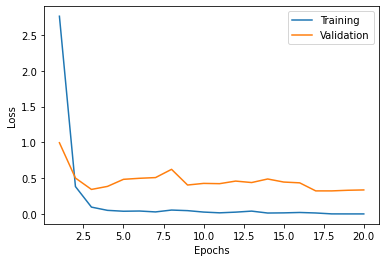

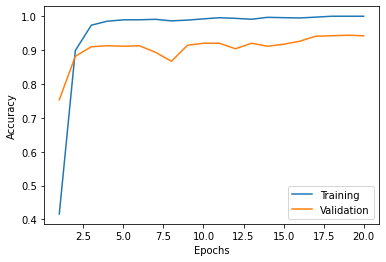

In [ ]:
x_plot = list(range(1,epochs +1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

In [ ]:
score = model_id.evaluate(x_test, y_id_test, verbose=0)
print("Test loss", score[0])
print("Test accuracy", score[1])

Test loss 0.4545690715312958
Test accuracy 0.9299867749214172


In [ ]:
predictions = np.argmax(model_id.predict(x_test), axis=1)
predictions = keras.utils.to_categorical(predictions, num_classes)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions, y_id_test))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       1.00      1.00      1.00         8
           2       1.00      0.89      0.94         9
           3       1.00      0.89      0.94         9
           4       1.00      0.73      0.84        11
           5       0.62      1.00      0.77         5
           6       1.00      1.00      1.00         8
           7       1.00      0.89      0.94         9
           8       0.88      1.00      0.93         7
           9       0.75      1.00      0.86         6
          10       0.88      1.00      0.93         7
          11       0.88      0.88      0.88         8
          12       1.00      0.80      0.89        10
          13       1.00      1.00      1.00         8
          14       1.00      0.89      0.94         9
          15       0.88      1.00      0.93         7
          16       1.00      0.89      0.94         9
          17       1.00    

# User identification and verification

In [ ]:
count = 0

for (img, id, is_genuine) in zip(x_test, y_id_test, y_01_test):
  prediction_01 = np.argmax(model.predict(np.array([img])), axis=1)
  prediction_01 = keras.utils.to_categorical(prediction_01, 2)[0]

  prediction_id = np.argmax(model_id.predict(np.array([img])), axis=1)
  prediction_id = keras.utils.to_categorical(prediction_id, 109)[0]

  if (prediction_01 == is_genuine).all() and (prediction_id == id).all():
    count += 1

In [ ]:
print("Identification and verification accuracy", count/len(y_id_test), "%")

Identification and verification accuracy 0.8916776750330251 %
